# Solving incompressible heat flow in a cavity

Let us consider the Stokes equations for the velocity $\mathbf{u}$ and the pressure $p$ of an incompressible fluid

\begin{align*} 
    \nabla \cdot \mathbf{u} &= 0,  \\
     \partial_t \mathbf{u} + \left( \mathbf{u}\cdot\nabla \right)\mathbf{u} + \nabla p - 2\mu \nabla \cdot \mathbf{D}(\mathbf{u}) &= 0,
\end{align*}

where  $\mathbf{D}(\mathbf{u}) = \mathrm{sym}(\mathbf{u}) = \frac{1}{2}\left(\nabla \mathbf{u} +  \left( \nabla \mathbf{u} \right)^{\mathrm{T}} \right)$ is the Newtonian fluid's rate of strain tensor and $\mu$ is the viscosity. 

Moreover, consider a convection-diffusion equation that governs the evolution of the temperature field
\begin{align*} 
    \partial_t T +\mathbf{u}\cdot\nabla T - \kappa \Delta T &= 0,
\end{align*}
where $\kappa$ is the constant thermal condictivity. 

The space domain is $\Omega = [0,L] \times [0,1]$, $L > 0$, and the space variable is $\mathbf{x}= \begin{pmatrix} x_0 \\ x_1 \end{pmatrix}$. Time domain is $[0,T]$, with $T>0$.

Boundary conditions for the velocity are 
\begin{align*} 
    \mathbf{u}(t,x_0,1) &= \begin{pmatrix} 1 \\ 0 \end{pmatrix}, &&  0 \leq x_0 \leq L \\
    \mathbf{u}(t,x_0,x_1) &= \begin{pmatrix} 0 \\ 0 \end{pmatrix} && \text{elsewhere on } \partial \Omega,
\end{align*}
and for the temperature field we set
\begin{align*} 
    T(t,0,x_1) &= T_h, && 0 \leq x_1 \leq 1, \\
    T(t,L,x_1) &= T_c, && 0 \leq x_1 \leq 1, \\
\end{align*}
for all $t \in [0,T]$.
Initial conditions are
\begin{align*} 
    \mathbf{u}(0,\mathbf{x}) &= \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \\
    T(0,\mathbf{x}) &= T_i.
\end{align*}


## Python packages

Import the Python packages for use in this notebook.

We need the finite element method library FEniCS.

In [1]:
import fenics

In [2]:
import dolfin
dolfin.__version__

'2019.2.0.dev0'

In [3]:
import ufl
ufl.__version__

'2019.2.0.dev0'

In [4]:
import pymor
pymor.__version__

'2020.2.2'

FEniCS has convenient plotting features that don't require us to import `matplotlib`; but using `matplotlib` directly will allow us to annotate the plots.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Benchmark parameters

Set constant Reynolds number and conductivity coefficient Kappa. For each we define a `fenics.Constant` for use in the variational form so that FEniCS can more efficiently compile the finite element code.

In [6]:
#dynamic_viscosity = 10.
Re = fenics.Constant(500)
#mu = fenics.Constant(dynamic_viscosity)
prandtl_number = 0.71
#Pr = fenics.Constant(prandtl_number)
kappa = fenics.Constant(1./0.71)

Furthermore the benchmark problem involves hot and cold walls with constant temperatures $T_h$ and $T_c$, respectively, and the initial temperature $T_i$ of the domain.

In [7]:
hot_wall_temperature = 0.5
T_h = fenics.Constant(hot_wall_temperature)
cold_wall_temperature = -0.5
T_c = fenics.Constant(cold_wall_temperature)
initial_temperature = 0.0
T_i = fenics.Constant(initial_temperature)

## Structured mesh definition
Now, define a structured mesh on the rectangle with bottom left corner $(0,0)$ and top right corner $(\bar{x},\bar{y}) = (L,1)$ and ratio $(\bar{x} - 0)/(\bar{y} - 0) = L$.

In [8]:
L = 1.2

In [9]:
if 0:
    N = 8
    mesh = fenics.UnitSquareMesh(N, N)
    ratio = 1.0
elif 1:
    ny = 10
    nx = int(ny*L)#1.0/ratio)
    mesh = fenics.RectangleMesh(fenics.Point(0, 0), 
                                fenics.Point(L, 1.0), nx, ny, "right/left")
else: 
    #unstructured mesh, mshr module needed
    domain = mshr.Rectangle(fenics.Point(0, 0), fenics.Point(L,1.0))
    mesh = mshr.generate_mesh(domain, 8)

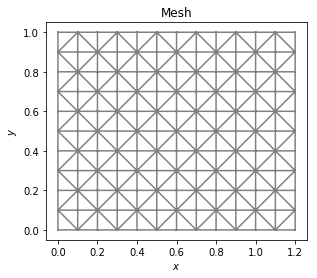

In [10]:
fenics.plot(mesh)
plt.title("Mesh")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [11]:
hy = 1./ny
hy

0.1

## Mixed finite element function space, test functions, and solution functions

Make the mixed finite element. We choose pressure and velocity subspaces analagous to the Taylor-Hood (i.e. P2P1) mixed element [1], but we extend this further with a P1 element for the temperature.

In [12]:
P1 = fenics.FiniteElement('P', mesh.ufl_cell(), 1)
P2 = fenics.VectorElement('P', mesh.ufl_cell(), 2)

#P2 = fenics.VectorFunctionSpace(mesh, 'P', 2)
#P1 = fenics.FunctionSpace(mesh, 'P', 1)

mixed_element = fenics.MixedElement([P1, P2,P1])

|Note|
|----|
|`fenics.FiniteElement` requires the `mesh.ufl_cell()` argument to determine some aspects of the domain (e.g. that the spatial domain is two-dimensional).|

Make the mixed finite element function space $\mathbf{W}$, which enumerates the mixed element basis functions for pressure, velocity and temperature on each cell of the mesh.

In [13]:
W = fenics.FunctionSpace(mesh, mixed_element)

Make the test functions $\psi_p,\boldsymbol{\psi}_u, \psi_T \in \mathbf{W}$.

In [14]:
# TestFunctions
psi_p, psi_u, psi_T = fenics.TestFunctions(W)

In [15]:
type(psi_p), type(psi_u), type(psi_T)

(ufl.indexed.Indexed, ufl.tensors.ListTensor, ufl.indexed.Indexed)

Make the Heat-Navier-Stokes system solution function $\mathbf{w} \in \mathbf{W}$ and obtain references to its components $p$, $\mathbf{u}, T$.

In [16]:
#solution functions
w = fenics.Function(W)
p, u, T = fenics.split(w)

#test functions
w_n = fenics.Function(W)
p_n, u_n, T_n = fenics.split(w_n)

## Time discretization

We are solving an initial value problem. We will prescribe the initial values, and then take discrete steps forward in time which solve the governing equations. For this we consider the initial values

\begin{align*}
    p^0  = 0,  \\
    \mathbf{u}^0 = \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \\
\end{align*}
and
\begin{align*}
    T^0  = T_h + x_0(T_c - T_h)\quad \text{ or } \quad T^0 = T_i.
\end{align*}

In [17]:
def initial_condition(constant = True):
    if (constant):
        w_n = fenics.interpolate(fenics.Expression(("0.", "0.", "0.","T_i" ), 
                                 T_i = initial_temperature,element = mixed_element),W)
    else:
        w_n = fenics.interpolate(fenics.Expression(("0.", "0.", "0.",
                                                    "T_h + x[0]*(T_c - T_h)" ),
                                                   T_h = hot_wall_temperature,
                                                   T_c = cold_wall_temperature,
                                                   T_i = initial_temperature,
                                                   element = mixed_element),W)
    #end    
     
    #endif
    return w_n

In [18]:
w_n = initial_condition(constant = True)
p_n, u_n, T_n = fenics.split(w_n)

Text(0, 0.5, '$y$')

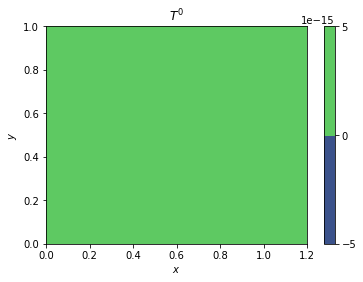

In [19]:
fig = fenics.plot(T_n)
plt.colorbar(fig)
plt.title("$T^0$")
plt.xlabel("$x$")
plt.ylabel("$y$")

For the time derivative terms $\mathbf{u}_t$ and $T_t$, we apply the first-order implicit Euler finite difference time discretization, i.e.

\begin{align*}
    \mathbf{u}_t = \frac{\mathbf{u}^{n+1} - \mathbf{u}^n}{\Delta t} \\
    T_t = \frac{T^{n+1} - T^n}{\Delta t}
\end{align*}

And we get a fully coupled (monolithic) system at each time step

\begin{align*} 
    \nabla \cdot \mathbf{u}^{n+1} &= 0  \\
    \frac{1}{\Delta t} \mathbf{u}^{n+1}  + \left( \mathbf{u}^{n+1}\cdot\nabla \right)\mathbf{u}^{n+1} + \nabla p - \mu \Delta \mathbf{u}^{n+1} &= \frac{1}{\Delta t} \mathbf{u}^n  \\
    \frac{1}{\Delta t}T^{n+1}  + \mathbf{u}^{n+1}\cdot\nabla T^{n+1} - \kappa \Delta T^{n+1} &= \frac{1}{\Delta t}T^{n}
\end{align*}

|Note|
|----|
|For our implementation, we will use the shorthand $\mathbf{w} = \mathbf{w}^{n+1}= \begin{pmatrix} p^{n+1} \\ \mathbf{u}^{n+1} \\ T^{n+1}\end{pmatrix}$. |

Choose a time step size $\Delta t$and set the time derivative terms.

In [20]:
timestep_size = 0.001
dt = fenics.Constant(timestep_size)
u_t = (u - u_n)/dt
T_t = (T - T_n)/dt

## Nonlinear variational form

Multiply equations by suitable test funcions $\psi_p, \boldsymbol{\psi}_u, \psi_T$ and integrate over the domain. We obtain

\begin{align*} 
    ({\psi}_p, \nabla \cdot \mathbf{u}^{n+1}) &= 0  \\
    \frac{1}{\Delta t}(\boldsymbol{\psi}_u, \mathbf{u}^{n+1}) + \left( \boldsymbol{\psi}_u,  ( \mathbf{u}^{n+1}\cdot\nabla) \mathbf{u}^{n+1} \right) -(p^{n+1}, \nabla \cdot \boldsymbol{\psi}_u) + \mu (\nabla \mathbf{u}^{n+1}, \nabla \boldsymbol{\psi}_u) -  \frac{1}{\Delta t}(\boldsymbol{\psi}_u, \mathbf{u}^{n}) &=0,\\
       \frac{1}{\Delta t} ({\psi}_T ,{T^{n+1}})  - (\mathbf{u}^{n+1}\cdot\nabla \psi_T, T^{n+1}) + \kappa(\nabla T^{n+1}, \nabla \psi_T) - \frac{1}{\Delta t} ({\psi}_T ,{T^{n}}) &= 0,
\end{align*}
where
\begin{align*}
b( \mathbf{u},\mathbf{v},\boldsymbol{\psi}_u) &= \left( ( \mathbf{u}\cdot\nabla) \mathbf{v}, \boldsymbol{\psi}_u \right).
\end{align*}

We can write the nonlinear system of equations as

\begin{equation*}
\mathbf{F}(\mathbf{w}) = \mathbf{0}.
\end{equation*}


In [21]:
inner, dot, grad, div, sym = \
    fenics.inner, fenics.dot, fenics.grad, fenics.div, fenics.sym
    
mass = -psi_p*div(u)

momentum = dot(psi_u, u_t + dot(grad(u), u)) - div(psi_u)*p \
    + 2.*(1./Re)*inner(sym(grad(psi_u)), sym(grad(u)))

energy = psi_T*T_t + dot(grad(psi_T), kappa*grad(T) - T*u)

F = (mass + momentum + energy )*fenics.dx

In [22]:
# stationary part of the variational form
F_stationary = (-psi_p*div(u)+
                dot(psi_u, dot(grad(u), u)) - div(psi_u)*p 
                + 2.*(1./Re)*inner(sym(grad(psi_u)), sym(grad(u))) 
                + dot(grad(psi_T), kappa*grad(T) - T*u))*fenics.dx

## Boundary conditions

We need boundary conditions before we can define a nonlinear variational *problem* (i.e. in this case a boundary value problem).
For the velocity, we consider the moving top lid 
\begin{align*}
    \mathbf{u}(1,x_1) &= 
    \begin{pmatrix} 1 \\ 0 \end{pmatrix}, 0 \leq x_1 \leq L.
\end{align*}
We physically consider *no slip* velocity boundary conditions for the orther boundaries. These manifest as homogeneous Dirichlet boundary conditions. For the temperature boundary conditions, we consider a constant hot temperature on the left wall, a constant cold temperature on the right wall, and adiabatic (i.e. zero heat transfer) conditions on the top and bottom walls. Because the problem's geometry is simple, we can identify the boundaries with the following piece-wise function.

\begin{align*}
    T(\mathbf{x}) &= 
    \begin{cases}
        T_h , && x_0 = 0, \\
        T_c , && x_0 = L.
    \end{cases}
\end{align*}

In [23]:
hot_wall = "near(x[0],  0.)" #x=0 

cold_wall = "near(x[0],"+str(L)+")" #x= \bar{x}

top_wall = "near(x[1],  1.)" #y=1

bottom_wall = "near(x[1],  0.)" #y=0

walls = hot_wall + " | " + cold_wall + " | " + bottom_wall

In [24]:
pressure_point = "near(x[0],  0.) & (x[1]<= "+str(hy)+")" #& near(x[1],  0.)

Define the boundary conditions on the appropriate subspaces.

In [25]:
W_p = W.sub(0)
# set velocity BC
boundary_conditions = [fenics.DirichletBC(W_p, 0. , pressure_point)]

In [26]:
# numbering starts at 0 -> W.sub(0) = W_p
W_u = W.sub(1)
# set velocity BC
boundary_conditions.extend([fenics.DirichletBC(W_u, (0., 0.), walls), 
                       fenics.DirichletBC(W_u, (1., 0.), top_wall)])

In [27]:
# set temperature BC

W_T = W.sub(2)
# set velocity BC
boundary_conditions.extend([fenics.DirichletBC(W_T, hot_wall_temperature, hot_wall), 
                             fenics.DirichletBC(W_T, cold_wall_temperature, cold_wall)])


In [28]:
boundary_conditions

## Nonlinear variational problem

Now we have everything we need to solve the variational problem.

In [29]:
def plot_w(w, split = False):
    
    if split:
        p, u, T = fenics.split(w.leaf_node())
    else:
        p, u, T  = w.split()   
    
    fig = fenics.plot(u)
    plt.title("Velocity vector field")
    plt.xlabel("$x$")
    plt.ylabel("$y$")    
    plt.colorbar(fig)  
    plt.show()

    
    fig = fenics.plot(p)
    plt.title("Pressure field")
    plt.xlabel("$x$")
    plt.ylabel("$y$")    
    plt.colorbar(fig)    
    plt.show()
    
    fig = fenics.plot(T)
    plt.title("Temperature field")
    plt.xlabel("$x$")
    plt.ylabel("$y$")    
    plt.colorbar(fig)    
    plt.show()
    
    return

In [30]:
def solve_fom_fenics(reynolds=1., nt = 1, plot = True, constant = False):
    
    # set Reynolds
    Re.assign(reynolds)
    # set initial solutions
    w_n = initial_condition(constant = constant)
    #p_n, u_n, T_n = fenics.split(w_n)
    # build output
    solution_vec = np.zeros((w.leaf_node().vector()[:].size,nt))
    
    t = 0
    for n in range(nt):

        # Update current time
        t += dt

        #solve
        fenics.solve(F == 0, w, boundary_conditions)

        #append solution
        solution_vec[:,n] = w.leaf_node().vector()[:].copy()
        
        # Update previous solution
        w_n.assign(w)
        if plot:
            plot_w(w)
        #endif
    #end
    
    return solution_vec

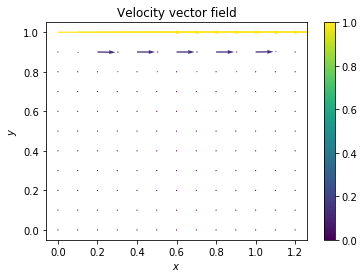

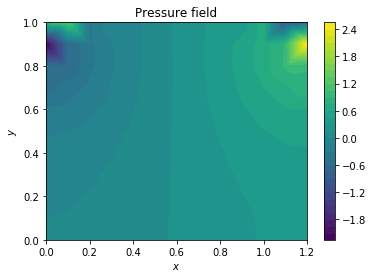

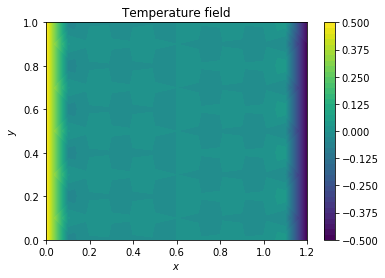

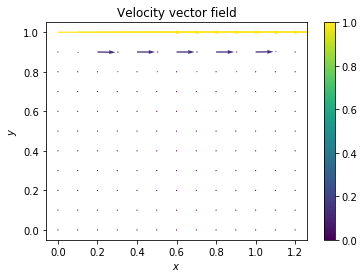

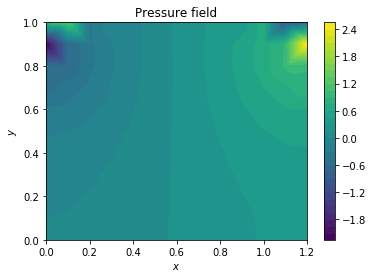

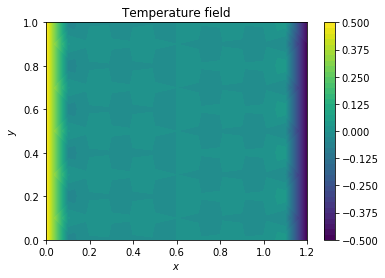

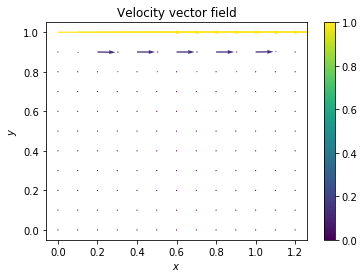

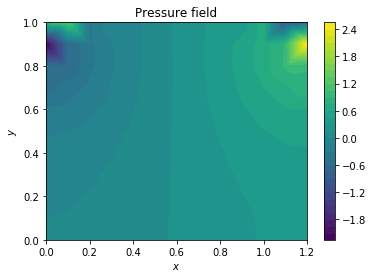

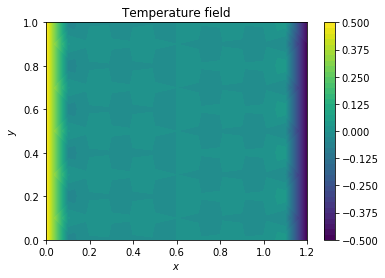

In [31]:
sol_fom_fe = solve_fom_fenics(reynolds=5., nt = 3)

|Note|
|----|
|`solver.solve` will modify the solution `w`, which means that `u`, `p` and `T` will also be modified.|

# ROM with Pymor

## Target parameters
 
$L, Re, T_i, T_c, T_h, \kappa$

In [32]:
# ### pyMOR wrapping
from pymor.bindings.fenics import FenicsVectorSpace, FenicsOperator, FenicsVisualizer
from pymor.models.basic import StationaryModel
from pymor.operators.constructions import VectorOperator

/home/pde_reduced_basis/.local/lib/python3.6/site-packages/pymor/core/config.py:23: UserWarning: FEniCS bindings have been tested for version 2019.1.0 (installed: 2019.2.0.dev0).
  warnings.warn(f'FEniCS bindings have been tested for version 2019.1.0 (installed: {df.__version__}).')


In [33]:
space = FenicsVectorSpace(W)

In [34]:
from pymor.tools.formatsrc import print_source

In [35]:
from pymor.basic import *

In [36]:
op = FenicsOperator(F_stationary, space, space, w, boundary_conditions,
                    parameter_setter=lambda mu: Re.assign(mu['Re'].item()),
                    parameters={'Re':1},
                    #parameters={'T_i': 1,'T_c': 1,'T_h':1,'kappa':1,'Re':1},
                    solver_options={'inverse': 
                                    {'type': 'newton', 'rtol': 1e-6, 'maxiter':500,
                                    'error_measure': 'residual'}})

In [37]:
rhs = VectorOperator(op.range.zeros())

/usr/local/lib/python3.6/dist-packages/matplotlib/quiver.py:665: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.6/dist-packages/matplotlib/quiver.py:665: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


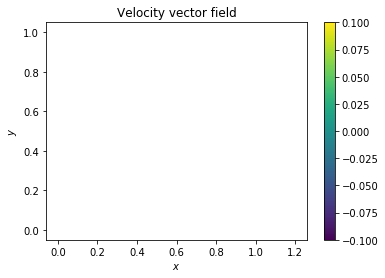

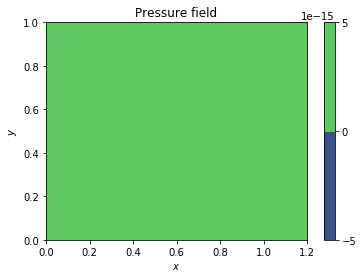

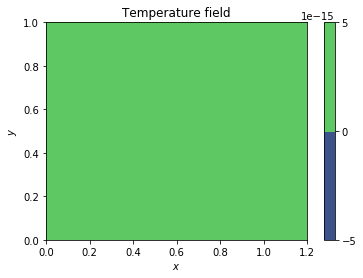

In [38]:
# set initial solutions
w_n = initial_condition()
fom_init = VectorOperator(op.source.make_array([ w_n.leaf_node().vector()[:] ]))

plot_w(w_n)

In [39]:
from pymor.algorithms.timestepping import ImplicitEulerTimeStepper

In [40]:
nt = 3
ie_stepper = ImplicitEulerTimeStepper(nt)

In [41]:
# define the instationary model   
fom = InstationaryModel(dt*nt, fom_init, op, rhs, time_stepper=ie_stepper,
                        visualizer=FenicsVisualizer(space) )

(n,1) -> (n,)

In [42]:
def solve_fom_pymor(Re=1., rtol=1e-6, return_residuals=True):
    mu = fom.parameters.parse(Re)
    UU = fom.solve(mu)
    
    return UU

In [43]:
U_py = solve_fom_pymor()

00:04 InstationaryModel: Solving InstationaryModel for {Re: [1.0]} ...


AssertionError: 

In [ ]:
# fom solution
plot_w(U_py)